In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import utils


In [3]:
gram_matrix = utils.gram_matrix
Normalization = utils.Normalization

## 'content loss function' and 'style loss function'
# content loss is the mean square error between feature maps of input and content images

class CL(nn.Module):
    def __init__(self, target):
        super(CL, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# style loss is the mean square error between gram matrix of input and style images
class SL(nn.Module):
    def __init__(self, target):
        super(SL, self).__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# define the number of features(channels)in nn.InstanceNorm2d() for different layers
IN_layers_default = [64,128,256,512]        

## Generating the 'Neural Style Transfer' Model
def nst_model(content_img, style_img, IN_layers = IN_layers_default):
    vgg = models.vgg19(pretrained=True).features.eval()
        
    normalization = Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    content_img = content_img.detach()
    style_img = style_img.detach()
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for name, layer in vgg._modules.items():
        
        # add BN after each Conv layer
        if name in ['0','2']: # conv_1
            model.add_module('conv_{}'.format(i),layer)
            model.add_module("InstanceNormalize_{}".format(i), nn.InstanceNorm2d(IN_layers[0]))
            i += 1             
        elif name in ['5','7']: # conv_2
            model.add_module('conv_{}'.format(i),layer)
            model.add_module("InstanceNormalize_{}".format(i), nn.InstanceNorm2d(IN_layers[1]))
            i += 1 
        elif name in ['10','12','14','16']: # conv_3
            model.add_module('conv_{}'.format(i),layer)
            model.add_module("InstanceNormalize_{}".format(i), nn.InstanceNorm2d(IN_layers[2]))
            i += 1 
        elif name in ['19','21','23','25']: # conv_4
            model.add_module('conv_{}'.format(i),layer)
            model.add_module("InstanceNormalize_{}".format(i), nn.InstanceNorm2d(IN_layers[3]))
            i += 1 
        elif name in ['28','30','32','34']: # conv_5
            model.add_module('conv_{}'.format(i),layer)
            model.add_module("InstanceNormalize_{}".format(i), nn.InstanceNorm2d(IN_layers[3]))
            i += 1 
            
        elif name in ['3','8','13','15','17','24','26','31','33','35']:
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            i += 1

        elif name in ['4','9','18','27','36']:
            model.add_module('maxpool_{}'.format(i),layer)
            i += 1

        elif name in ['1','6','11','20','29']:
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            style_target = model(style_img)
            style_loss = SL(style_target)
            style_losses.append(style_loss)
            model.add_module('styleloss_{}'.format(i),style_loss)
            i += 1
            
        elif name == '22':
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            content_target = model(content_img)
            content_loss = CL(content_target)
            content_losses.append(content_loss)
            model.add_module('contentloss_{}'.format(i),content_loss)
            i += 1 
            
    return model, style_losses, content_losses

Step : [0]
Style Loss : 6.904977 Content Loss: 0.000000
Step : [50]
Style Loss : 3.575590 Content Loss: 0.020604
Step : [100]
Style Loss : 1.772996 Content Loss: 0.031838
Step : [150]
Style Loss : 1.002916 Content Loss: 0.033879
Step : [200]
Style Loss : 0.619457 Content Loss: 0.035812
Step : [250]
Style Loss : 0.444122 Content Loss: 0.038059
Step : [300]
Style Loss : 0.368024 Content Loss: 0.040267
time cost: 518.2667906284332


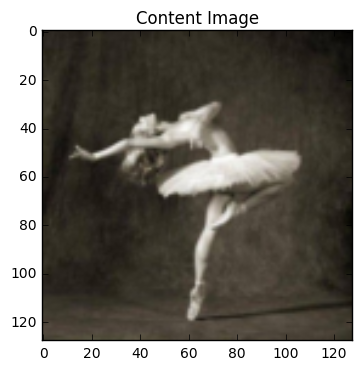

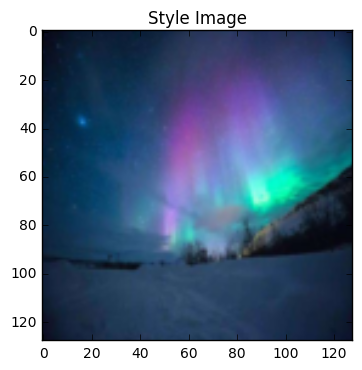

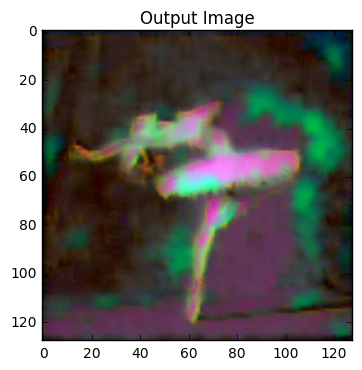

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import model
import utils
from time import time


nst = nst_model
loader = utils.loader
imshow = utils.imshow


def main(content_img,style_img,size,steps,c_weight,s_weight):
#content_img,style_img,size,steps,c_weight,s_weight

    content_img, style_img = loader(content_img, style_img, size = size)
    input_img = content_img.clone() # just noise array is fine


    model, style_losses, content_losses  = nst(content_img, style_img)

    optimizer = optim.LBFGS([input_img.requires_grad_()],lr = 0.01)

    step = [0]
    while step[0] <= steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            output = model(input_img)

            cl = 0
            sl = 0
            i = 0
            for c_loss in content_losses:
                cl += c_loss.loss * c_weight[0]
            for s_loss in style_losses:
                sl += s_loss.loss * s_weight[i]
                i += 1

            loss = cl + sl
            loss.backward()

            if step[0] % 50 == 0:
                print('Step : {}'. format(step))
                print('Style Loss : {:3f} Content Loss: {:3f}'.format(
                    sl.item(), cl.item()))

            step[0] += 1

            return loss
            #print(IN_style_loss)
            #print(IN_content_loss)
        optimizer.step(closure)

    input_img.data.clamp_(0,1)
    return input_img

    imshow(content_img, title = 'Input image')
    plt.show()
    
def imshow(image, title = None,save_path = None):
    image = image.clone()
    image = image.squeeze(0)
    pil = transforms.ToPILImage()
    target_img_PIL = pil(image)
    plt.figure()
    plt.imshow(target_img_PIL)
    if title is not None:
        plt.title(title)
    if save_path is not None:
        target_img_PIL.save(save_path) 
    plt.pause(1)
if __name__ == "__main__":
    
    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    start = time()
    output = main(content_img='./images/dancing.jpg',style_img='images/oruora1.jpg',size=128,steps=300,c_weight=content_weights,s_weight=style_weight )
    print('time cost:',time()-start)
    plt.figure()
    imshow(output, title = 'Output Image',save_path = './results/IN_dancing_oruora1.jpg')
    plt.pause(5)
    plt.show()

In [5]:
IN_style_loss = [5.073591,1.860508,0.469408,0.142425,0.065292,0.045168,0.038672,0.033755,0.030493,0.027935,0.025687,0.024382,0.023498,0.022829,0.022321,0.021890,0.021445]
IN_content_loss = [0.000000,0.023698,0.025318,0.020784,0.019559,0.020135,0.020124,0.017863,0.015535,0.013956,0.012998,0.012425,0.011968,0.011593,0.011232,0.010925,0.010677]
#性能对比的标准调整
def exchange(WN_loss):
    Initial_style_loss = IN_style_loss[0]
    rate = Initial_style_loss / WN_loss
    
    print('Exchanged Style loss:')
    for i in IN_style_loss:
        print(i/rate)
    print('Exchanged Content loss:')
    for j in IN_content_loss: 
        print(j/rate)
exchange(1176.177979) 

Exchanged Style loss:
1176.177979
431.30960681563255
108.81983840763515
33.017471975781056
15.136224540935208
10.471007015636854
8.965081104071652
7.825204609741897
7.068996123977475
6.475991431584651
5.954852045932162
5.652322286912367
5.447390250917349
5.292300282500304
5.174533908874208
5.07461795014813
4.97145646144023
Exchanged Content loss:
0.0
5.493754964943371
5.869309148554151
4.818221081584227
4.534237208174841
4.667767584569785
4.665217525298353
4.141064433234173
3.6013791619712743
3.235329744735829
3.013242764551183
2.8804078588666293
2.7744644873171684
2.6875306485183765
2.6038423397014068
2.532672503671463
2.4751802582791953
17
17
